# Learning a family of functions
---

## Task 1 - Creating the training dataset and dataloader 
---

### Generation of family of cureves data 
- First, we select a random value of c in between (5,25) and then randomly select c values from 40 points of functions  {𝑓𝑎}  and save as (Xc, Yc) 
- Second, we save Xt values along with Yt values of functions  {𝑓𝑎} as random.

In [2]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt

In [11]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
fa = a*torch.sin(x+a)   # final equation for fa(x) = a*sin(x+a) storing all functions 

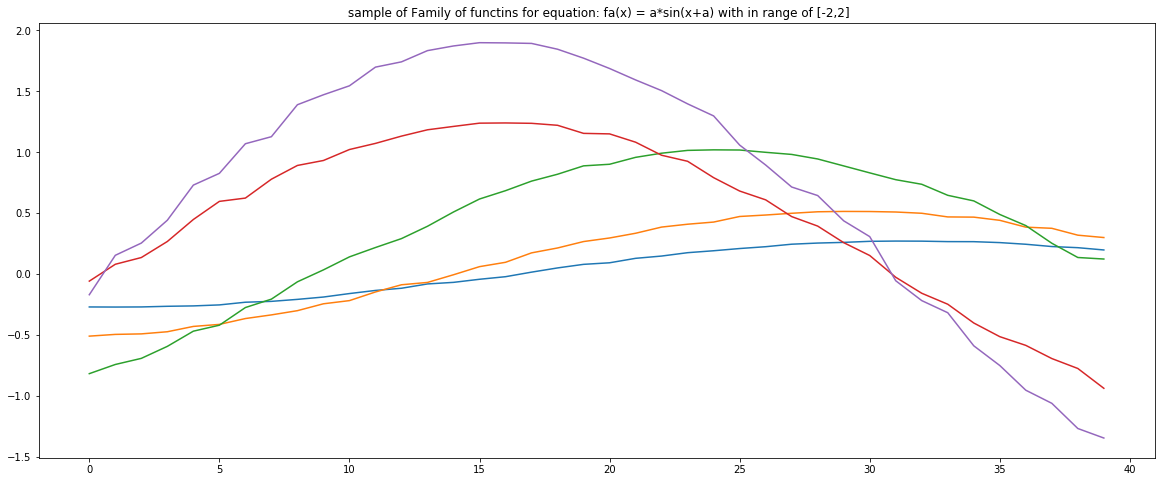

In [12]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20,8))
plt.title(" sample of Family of functins for equation: fa(x) = a*sin(x+a) with in range of [-2,2]")
for i in range(5):
    # Plotting 5 sample plots from family of functions 
    plt.plot(fa[i,:,0])
    

### Making training dataset 
- The values of (Xc, Yc) with Xt are saved as DataX and Yt values as DataY
- Then we use train_test_split from sklearn to split the data in X_train, X_test, y_train, y_test with the test set being chosen from fully random 30% of all data.
- Where we will use X_train and y_train to train the model and X_test and y_test to test the learning rate 


In [13]:
import numpy as np 

dataX = []          # will store the (Xc, Yc) and Xt
dataY = []          # will store the Yt values

for i in range(Nf):
    random_subset = []      # will store the radomly selected (Xc, Yc) values
    x_t_values = []         # will store the Xt value
    y_t_values = []         # will store the Yt value
    
    random_subset_len = np.random.randint(5,25)  ### fixing it to make subset of minimum size 5 and max 25
    temp = np.arange(Npts) 
    
    np.random.shuffle(temp)                      ### randomizing so that we have randomly saved (Xt, Yt) values
    for j in temp[:random_subset_len]:
        random_subset.append([x[i,j,0],fa[i,j,0]])
        
    for j in temp[:]:                          ### Saving all (Xt,Yt) values 
        x_t_values.append(x[i,j,0])
        y_t_values.append(fa[i,j,0])       
        
    dataX.append([random_subset, x_t_values])  ### making dataX and dataY for splitting it later
    dataY.append(y_t_values)
    
dataX = np.array(dataX)                        ### Converting list to numpy array
dataY = np.array(dataY)        

### Test and Train split 
- One of important steps in Machine learning, here we split  our  data in 2 sets 70% is for training and 30% for testing
- the 70 and 30 sets are randomly choosen from full data

In [14]:
from sklearn.model_selection import train_test_split

### Splitting the data in Training and testing set with test size 30%

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY,  test_size=0.3, random_state=42)

### Below is the sample input which our model will get, We plot the (Xt, Yt) values and corresponding (Xc,Yc) values

#### Sample (Xt,Yt) values 

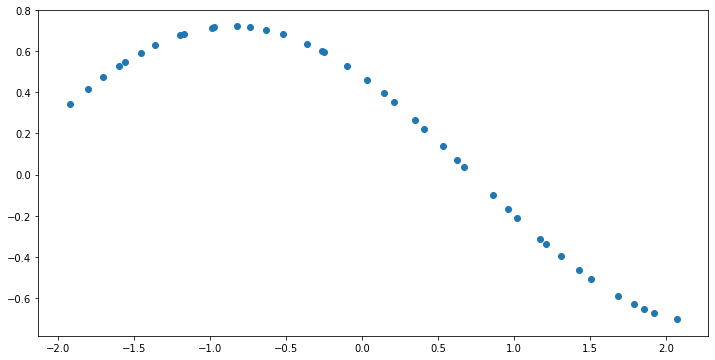

In [15]:
x = [] # for storing x and y point in scatter plots
y = []
for i in range(len((X_train[0,:][1]))):
    x.append(X_train[0,:][1][i].detach().numpy())    # converting from tensor to numpy
    y.append(y_train[0][i])

fig = plt.figure(figsize=(12,6))
plt.scatter(x,y)

#### Sample (Xc,Yc) values 

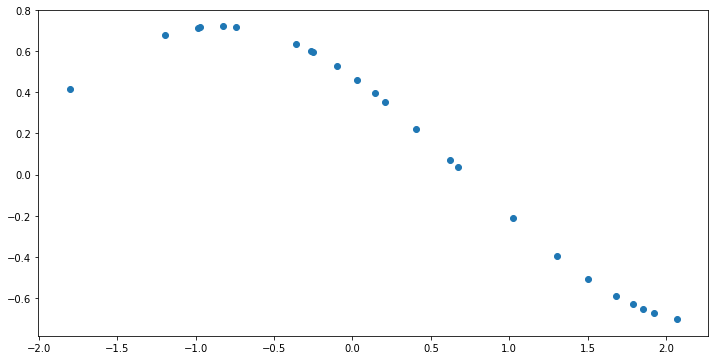

In [16]:
x = []  # for storing x and y point in scatter plots
y = []
for i in range(len(X_train[0,:][0])):
    x.append(X_train[0,:][0][i][0].detach().numpy())    # converting from tensor to numpy
    y.append(X_train[0,:][0][i][1].detach().numpy())  
    
fig = plt.figure(figsize=(12,6)) 
plt.scatter(x,y)

## Task 2 - Create the Encoder and Decoder
---

### Encoder Part
- Things needed to do
    - We will have to supply all (Xc,Yc) points to Encoder part 
    - Have to calculate the average of R points
    
- How its done
    - Encoder takes in all (Xc,Yc) points as an array of tensor; example shape (23,2)
    - It goes through layers of feed forward network and finally gives values of dimentions of R*no_of_(Xc,Yc)_points
    - Then we take the mean of all the values and finally and we get final R points 

### Decoder Part 
- Decoder part is bit simple, it just takes one value of Xt from all possible (Xt,Yt) values and then gives only one value as output 

### Encoder-Decoder architecture
- We have one encoder and one decoder object in our Encoder-Decoder model, 
- It takes in all (Xc,Yc) values and pass it to Encoder part and we get R values 
- we add Xt with R values from encoder to pass it to decoder 
- decoder predicts a value and model returns that value 

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [141]:
class Encoder(nn.Module):
    """
    Encoder will take (Xc,Yc) as input and finally give average of Rc values as output
    """
    def __init__(self, input_dim=2, hidden_layer=256, output_dim=1):
        super().__init__() 
        # Input layer with shape dependent on input dimentions which will be 2
        self.linear_1 = nn.Linear(input_dim, hidden_layer)
        # Hidden layer 1
        self.linear_2 = nn.Linear(hidden_layer, hidden_layer)
        # Adding a dropout for better rusults 
        self.dropout = nn.Dropout(0.1)
        # Hidden layer 2
        self.linear_3 = nn.Linear(hidden_layer, hidden_layer)
        # Final output layer with output size equal to R_dim 
        self.linear_4 = nn.Linear(hidden_layer, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = self.dropout(F.relu(self.linear_2(x)))
        x = F.relu(self.linear_3(x))
        x = self.linear_4(x)
        # untill here the x would depend upon number of inputs and after taking mean along axis=0 means we are 
        # taking mean over all values of (Xc,Yc)
        
        x = torch.mean(x,axis=0)
        return x
    
class Decoder(nn.Module):
    """
    Decoder will take output from encoder and Xt value and will give expected Yt value in output
    """
    def __init__(self, input_dim=2, hidden_layer=256, output_dim=1):
        super().__init__() 
        # Input layer with shape dependent on input dimentions which will be R_dim+1
        self.linear_1 = nn.Linear(input_dim, hidden_layer)
        # Hidden layer 1
        self.linear_2 = nn.Linear(hidden_layer, hidden_layer)
        # Adding a dropout for better rusults 
        self.dropout = nn.Dropout(0.1)
        # Hidden layer 2
        self.linear_3 = nn.Linear(hidden_layer, hidden_layer)
        # Final output layer with output size equal to 1
        self.linear_4 = nn.Linear(hidden_layer, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = self.dropout(F.relu(self.linear_2(x)))
        x = F.relu(self.linear_3(x))
        x = self.linear_4(x)
        return x
    
class Encoder_Decoder(nn.Module):
    """
    Joinging the above 2 classes to make the encoder_decoder as one MLP model
    """
    def __init__(self, input_dim=2,r_dim=1, hidden_layer=256, output_dim=1):
        super().__init__() 
        # Creating Encoder object with passing the arguments 
        self.encoder = Encoder(input_dim=2, hidden_layer=256, output_dim=r_dim)
        # Creating Decoder object with proper arguments
        self.decoder = Decoder(input_dim=1+r_dim, hidden_layer=256, output_dim=1)
        
    def forward(self, x, xt):
        # x will contain all the (Xc, Yc) values 
        # xt will contain only one xt value 
        
        xr = self.encoder(x)
        
        # temp is the list which will store R values and we will append Xt to it to make input of Decoder part
        temp = []
        temp.extend(xr)
        temp.append(xt)
        
        # passing the temp to decoder after making it a tensor
        x = torch.tensor(temp)
        x = self.decoder(x)
        return x
    
    

## Task 3 - Create the optimizer and loss for your model
---
### Training 

### Hyper paremeters

In [1]:
EPOCHS = 5              # total no of times model we see the training data
hidden_layers = 512     # no of neurons in hidden layers in encoder and decoder part 
lr = 1e-3               # learning rate for traing and optimization 
r_dim = 64              # R_Dim, dimensions of the R points 

### Loss and Optimizer
- We use MSE loss to compute the loss value while training; We use the Torch inbuild MSE loss from *torch.nn.MSELoss()*
- We use Adam optimizer with learing rate defined above as hyper parameter, We use Torch inbuild Adam optimizer from *torch.optim.Adam()*

In [146]:
# Model  
model = Encoder_Decoder(input_dim=2,r_dim=r_dim, hidden_layer=hidden_layers, output_dim=1)

# Optimizer 
optimiser = torch.optim.Adam(model.parameters(), lr=lr,)

# loss function 
loss_fn = torch.nn.MSELoss()

## Task 4 - Write the training script that will train the model and print the training loss
---
- First we made a for loop over number of epochs so that same model can see the whole data no of epochs times 
- Then we ran over all family of functions one by one 
- We extract X value from training data which contains (Xc,Yc) and Xt 
- Feeding all (Xc,Yc) values into the model and Xt values one by one 
- After we feed first Xt value we get some prediction of Yt 
- We apply loss function which is MSE loss; over predicted Yt and real Yt value
- After getting loss; the model takes the optimization step and backward propogations 
- And, after every 100 family of functions; we chech the learning progress by computing loss over test set. 


### Training Model 

In [159]:
loss_values = []    # will store the total loss values over training 
test_loss = []      # will store the test loss over training 

for e in range(EPOCHS):          # Looping over number of Epochs
    print('epoch: ',e)
    
    for i in range(X_train.shape[0]):        # Looping over all training data
        x = torch.tensor(X_train[i,:][0])    # contains (Xc,Yc)
         
        set_loss = []
        for xt_i in range(len(X_train[i,:][1])):  # iterating over all Xt values 
            optimiser.zero_grad()
            
            xt = X_train[i,:][1][xt_i]            # one Xt value
            yt = torch.tensor([y_train[i][xt_i]]) # one Yt value 
            
            # Forward pass
            y_t_predict = model(x, xt)            # predicting Yt
            
            loss = loss_fn(y_t_predict, yt)       # MSE loss 
 
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimiser.step()
            
            set_loss.append(round(float(loss.detach().numpy()),4))  # adding one (Xt,Yt) prediction loss 
            
        loss_values.append(sum(set_loss)/len(set_loss))             # adding all (Xt,Yt) loss from one family of function
                                                                    # in loss values list which will be our training loss.
        
        if i%100 == 0 and i!=0:
            # checking the test loss and train loss after every 100 iters
            print( f"{round((i/X_train.shape[0])*100,2)}% complete,",  "loss: ",round(sum(set_loss)/len(set_loss),3),end=" " )
            
            # without changing the weights we will test our current model over test data and will print the loss value
            with torch.no_grad():
                
                for i in range(X_test.shape[0]):
                    x = torch.tensor(X_test[i,:][0])

                    for xt_i in range(len(X_test[i,:][1])):
                        
                        xt = X_test[i,:][1][xt_i]
                        yt = torch.tensor(y_test[i][xt_i])

                        # Forward pass
                        y_t_predict = model(x, xt)

                        loss = loss_fn(y_t_predict, yt)
                        test_loss.append(float(loss.detach().numpy()))
                        
                print("test loss: ", round((sum(test_loss)/len(test_loss)),3)) # print the test loss average over all (Xt,Yt) predictions 


epoch:  0


/home/vaibhav/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


7.14% complete, loss:  0.343 test loss:  0.212
14.29% complete, loss:  0.173 test loss:  0.195
21.43% complete, loss:  0.065 test loss:  0.18
28.57% complete, loss:  0.063 test loss:  0.221
35.71% complete, loss:  0.022 test loss:  0.206
42.86% complete, loss:  0.079 test loss:  0.192
50.0% complete, loss:  0.019 test loss:  0.174
57.14% complete, loss:  0.012 test loss:  0.161
64.29% complete, loss:  0.01 test loss:  0.151
71.43% complete, loss:  0.028 test loss:  0.141
78.57% complete, loss:  0.018 test loss:  0.132
85.71% complete, loss:  0.046 test loss:  0.126
92.86% complete, loss:  0.019 test loss:  0.121
epoch:  1
7.14% complete, loss:  0.039 test loss:  0.118
14.29% complete, loss:  0.035 test loss:  0.114
21.43% complete, loss:  0.04 test loss:  0.111
28.57% complete, loss:  0.108 test loss:  0.115
35.71% complete, loss:  0.009 test loss:  0.111
42.86% complete, loss:  0.046 test loss:  0.11
50.0% complete, loss:  0.018 test loss:  0.107
57.14% complete, loss:  0.015 test los

### Training loss with moving average for better visualization

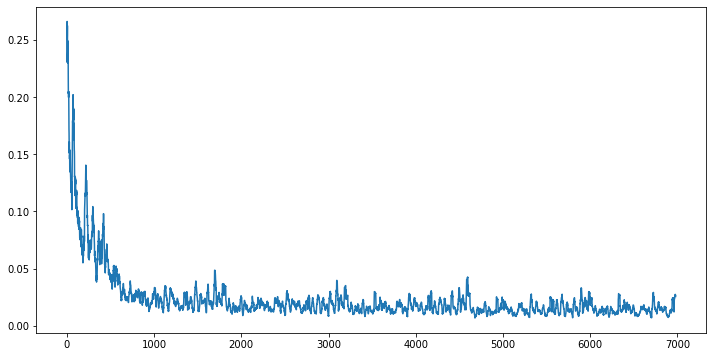

In [206]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))  # cumulative sum for running mean
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Plotting the training loss 
fig = plt.figure(figsize=(12,6))
loss_rolling_mean = running_mean(loss_values, 20)
plt.plot(loss_rolling_mean)

### Save model 

In [119]:
# torch.save(model, 'models/encoder_decoder_r64')

In [120]:
# model = torch.load('models/encoder_decoder_r64')

## Task 5 - Evaluate the model on some validation data, Plot some predictions 
---

### Testing results 

In [168]:
import random

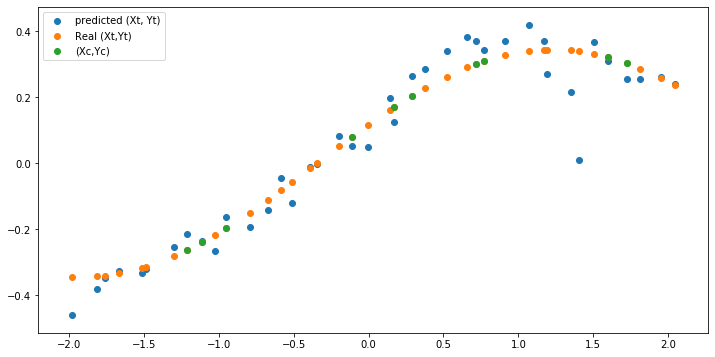

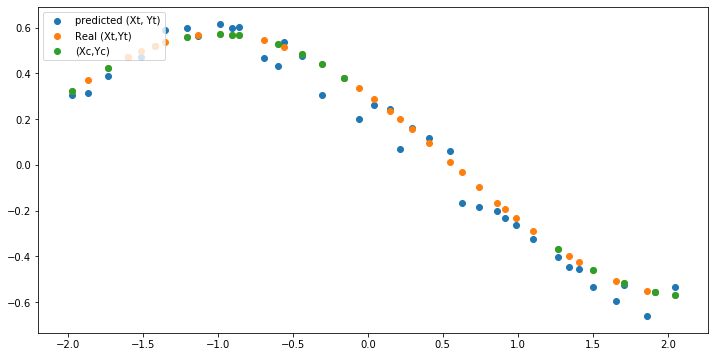

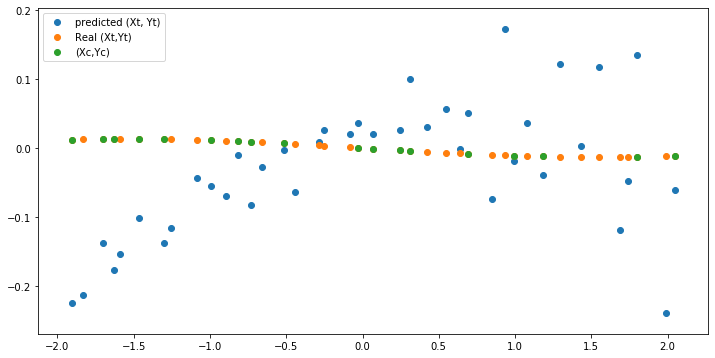

In [200]:
no_of_test_sample = 3                           # number of test results want to print 
with torch.no_grad():                           # without changing gradients/ just testing 
    
    for i in random.choices(range(X_test.shape[0]),k=no_of_test_sample):   # randomly choose k numbers from test data len
        x = torch.tensor(X_test[i,:][0])        # get x from training data
        y = []                                  
        y_real = []
        xt_l = []
        for xt_i in range(len(X_test[i,:][1])):

            xt = X_test[i,:][1][xt_i]           # final adjustments for inputting in the model
            yt = torch.tensor(y_test[i][xt_i])
            y_real.append(yt.detach().numpy())
            
            # Forward pass
            y_t_predict = model(x, xt)          # model predictions 
            y.append(y_t_predict.detach().numpy())
            xt_l.append(xt.detach().numpy())
            
        fig = plt.figure(figsize=(12,6))        # plotting the results 
        plt.scatter(xt_l, y,label='predicted (Xt, Yt)')    # predicted (Xt, Yt)
        plt.scatter(xt_l, y_real,label='Real (Xt,Yt)')     # Real (Xt,Yt)
        plt.scatter(x[:,0], x[:,1],label='(Xc,Yc)')        # (Xc,Yc) given
        
        plt.legend(loc='upper left')
        plt.show()
        

# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 
* We iterate over all functions, extract (Xc,Yc) points and Xt points, Make it in the way our model will understand and then store the value of Yt 
* Finally we print Expected (Xt,Yt) values along with (Xc,Yc) values to know how good our model learned 

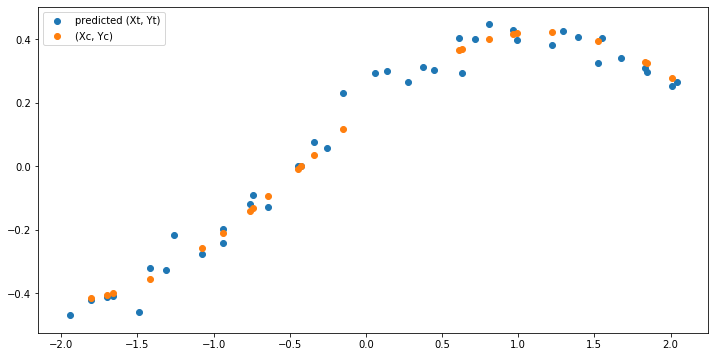

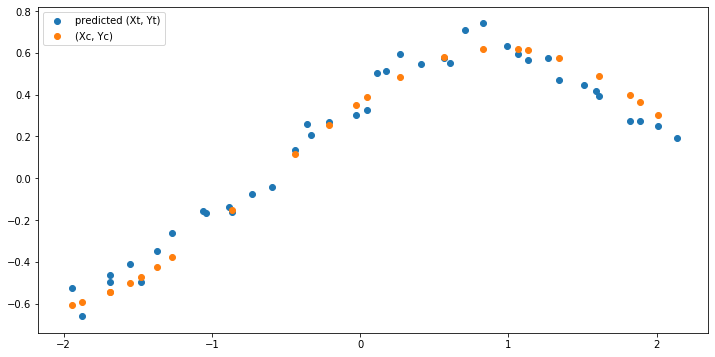

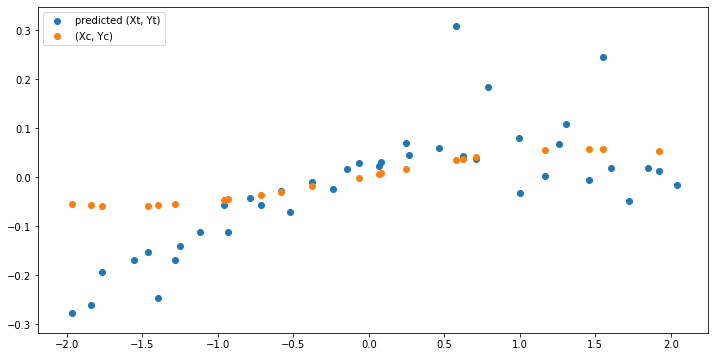

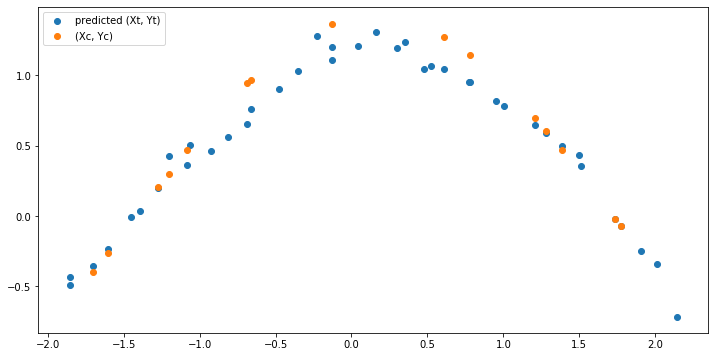

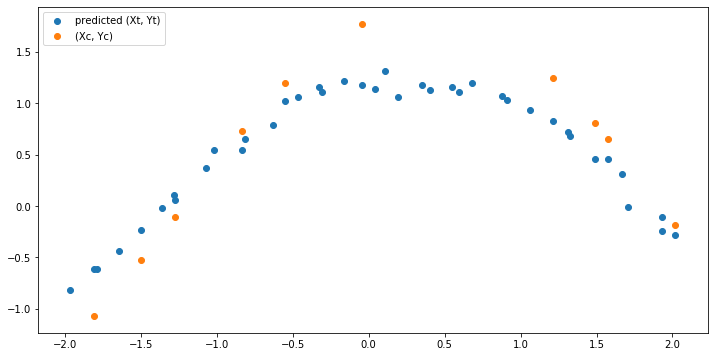

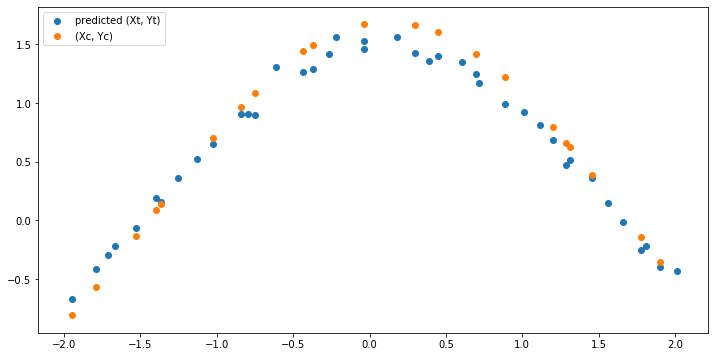

In [202]:
import pickle
path_to_the_pickle = 'test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
for i in range(1,7):                          ## iterating over all functions 
    name= 'function_num_{}'.format(i)
    x_c=test_data[name]['context_pairs'][0]
    y_c=test_data[name]['context_pairs'][1]
    x_t =test_data[name]['x']
    
    x_c = x_c.reshape(-1,1)
    y_c = y_c.reshape(-1,1)
    x_t = x_t.reshape(-1,1)
    
    x = torch.cat((x_c, y_c), dim=1)
    
    fig = plt.figure(figsize=(12,6))
    
    with torch.no_grad():    
        y_t = []

        x_l = []
        for xt_i in range(x_t.shape[0]):

            xt = torch.tensor([x_t[xt_i][0]])

            # Forward pass
            y_t_predict = model(x,xt)
            y_t.append(y_t_predict.detach().numpy())
            x_l.append(x_t[xt_i][0].detach().numpy())
            
    plt.scatter(x_l, y_t, label='predicted (Xt, Yt)')
    plt.scatter(x[:,0], x[:,1], label='(Xc, Yc)')
    plt.legend(loc='upper left')